In [7]:
import torch
# Config

DATA_DIR = 'data/'
CHECKPOINT_DIR = 'checkpoints/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 24
lr = 0.01

In [8]:
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageNetChallengeDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + '.jpg')
        image = read_image(img_path) / 255
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip()
    ])
training_data = ImageNetChallengeDataset(DATA_DIR + 'train.csv', DATA_DIR + 'train', transform=preprocess, target_transform=lambda x : x-1)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

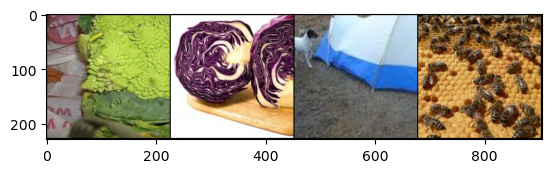

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out)

In [10]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model = resnet50(weights=ResNet50_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        
        epoch_loss = running_loss / len(training_data)
        epoch_acc = running_corrects.double() / len(training_data)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        torch.save(model.state_dict(), CHECKPOINT_DIR + 'snapshot' + str(epoch) + '.pt')

        if epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

In [14]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 1/24
----------
Loss: 0.1187 Acc: 0.9595
Epoch 2/24
----------
Loss: 0.0927 Acc: 0.9663
Epoch 3/24
----------
Loss: 0.0910 Acc: 0.9675
Epoch 4/24
----------
Loss: 0.0913 Acc: 0.9715
Epoch 5/24
----------
Loss: 0.0702 Acc: 0.9750
Epoch 6/24
----------
Loss: 0.0670 Acc: 0.9760
Epoch 7/24
----------
Loss: 0.0559 Acc: 0.9815
Epoch 8/24
----------
Loss: 0.0536 Acc: 0.9828
Epoch 9/24
----------
Loss: 0.0508 Acc: 0.9823
Epoch 10/24
----------
Loss: 0.0539 Acc: 0.9810
Epoch 11/24
----------
Loss: 0.0511 Acc: 0.9843
Epoch 12/24
----------
Loss: 0.0548 Acc: 0.9823
Epoch 13/24
----------
Loss: 0.0381 Acc: 0.9878
Epoch 14/24
----------
Loss: 0.0490 Acc: 0.9833
Epoch 15/24
----------
Loss: 0.0498 Acc: 0.9835
Epoch 16/24
----------
Loss: 0.0458 Acc: 0.9843
Epoch 17/24
----------
Loss: 0.0432 Acc: 0.9863
Epoch 18/24
----------
Loss: 0.0459 Acc: 0.9833
Epoch 19/24
----------
Loss: 0.0437 Acc: 0.9853
Epoch 20/24
----------
Loss: 0.0440 Acc: 0.9850
Epoch 21/24
----------
Loss: 0.0499 Acc: 0.9838
E